# Ejercicios Dask

In [86]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, processes=True, memory_limit='2GB', dashboard_address=':8794')
client

/Users/andres/Documents/ITAM/Quinto Semestre/Fuentes de datos/proyecto_dask/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8794 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57557 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57557/status,
Dashboard: http://127.0.0.1:57557/status,Workers: 2
Total threads: 8,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57558,Workers: 2
Dashboard: http://127.0.0.1:57557/status,Total threads: 8
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:57565,Total threads: 4
Dashboard: http://127.0.0.1:57567/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:57561,


## 1. Arreglo de Dask

Suma de números del 1 al 1000: 500500


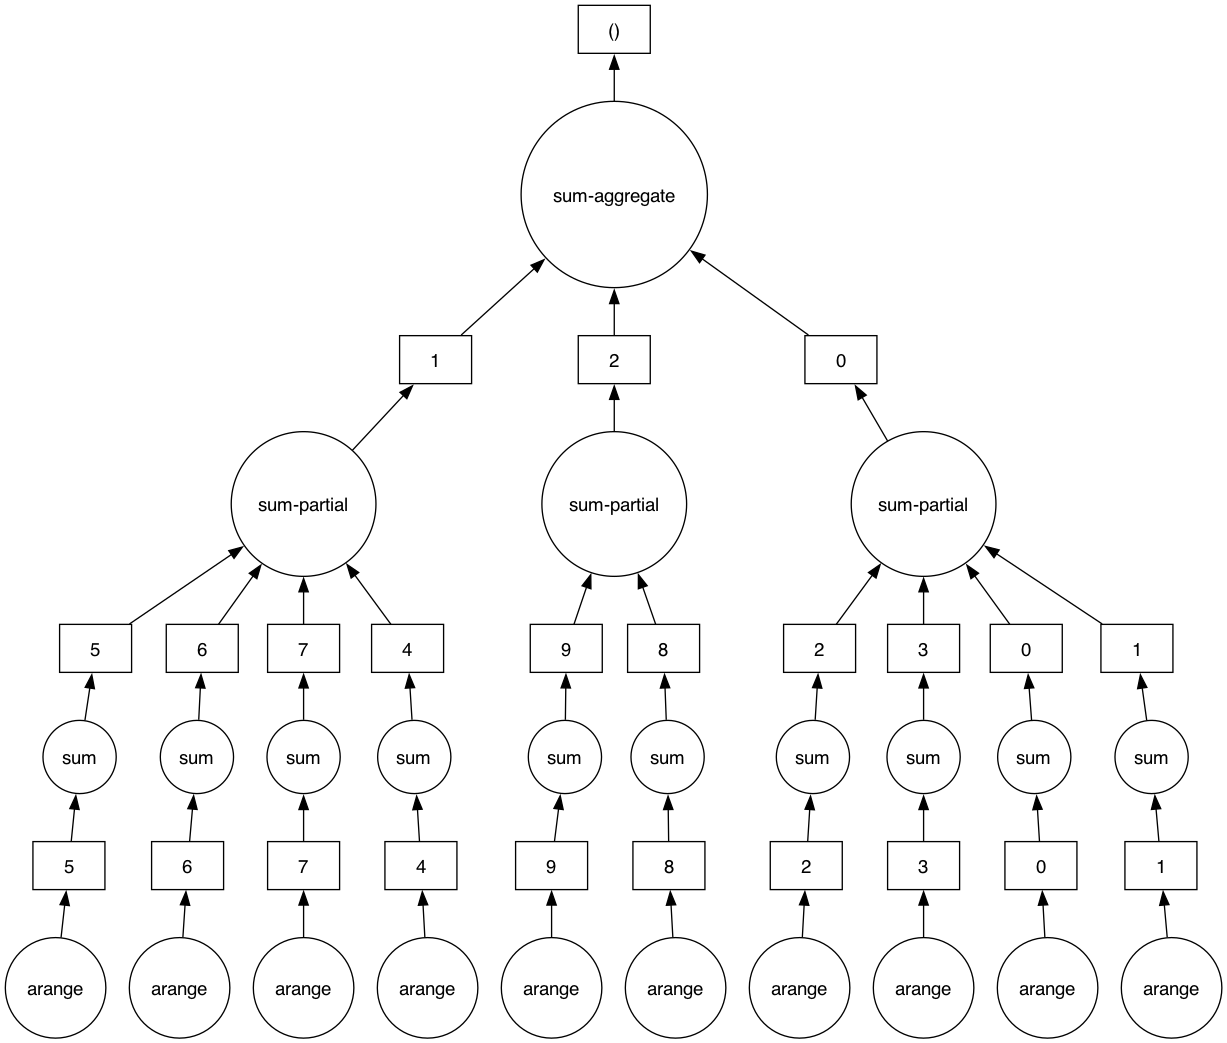

In [87]:
import dask.array as da
x = da.arange(1, 1001, chunks=100)
result = x.sum().compute()

print("Suma de números del 1 al 1000:", result)

x.sum().visualize()

¿De cuántos elementos (dimensión) son los *chunks* y cuántos hay?

## 2. Dataframe de Dask

In [88]:
import dask.dataframe as dd

df = dd.read_csv("data/nycflights/*.csv")

mean_delays = df.groupby("Month")["DepDelay"].mean().compute()

print("Promedio de retrasos por mes:")
mean_delays

Promedio de retrasos por mes:


Month
1     11.288756
2      9.742895
3      9.848378
4      7.972364
5      7.556340
6     11.015031
7     12.037985
8     10.429337
9      6.477262
10     6.097712
11     6.986246
12    11.017244
Name: DepDelay, dtype: float64

¿Cuántos archivos se están leyendo en `dd.read_csv()`?
¿Cómo verías el gráfico de tareas (y dónde pondrías el comando)?

## 3. Bolsas de Dask

In [89]:
import dask.bag as db
import json
import os

os.makedirs('data/jsons', exist_ok=True)

for i in range(5):  # Generar 5 archivos JSON
    data = [{"name": f"Person_{j}", "age": 20 + (j % 15), "city": f"City_{j % 3}"} for j in range(1000)]
    with open(f"data/jsons/data_{i}.json", "w") as f:
        for record in data:
            f.write(json.dumps(record) + "\n")

# Leer los archivos JSON con Dask Bag
bag = db.read_text("data/jsons/*.json").map(json.loads)

# Filtrar personas mayores de 30 años
filtered_bag = bag.filter(lambda x: x["age"] > 30)

# Calcular la edad promedio de las personas mayores de 30 años
average_age = filtered_bag.pluck("age").mean().compute()

# Mostrar el resultado
print(f"Edad promedio de las personas mayores de 30 años: {average_age}")


Edad promedio de las personas mayores de 30 años: 68.92333371704846


¿Qué hacen `map`, `filter`, `pluck`?

## 4. Delayed 

Resultado total: 49999995000000


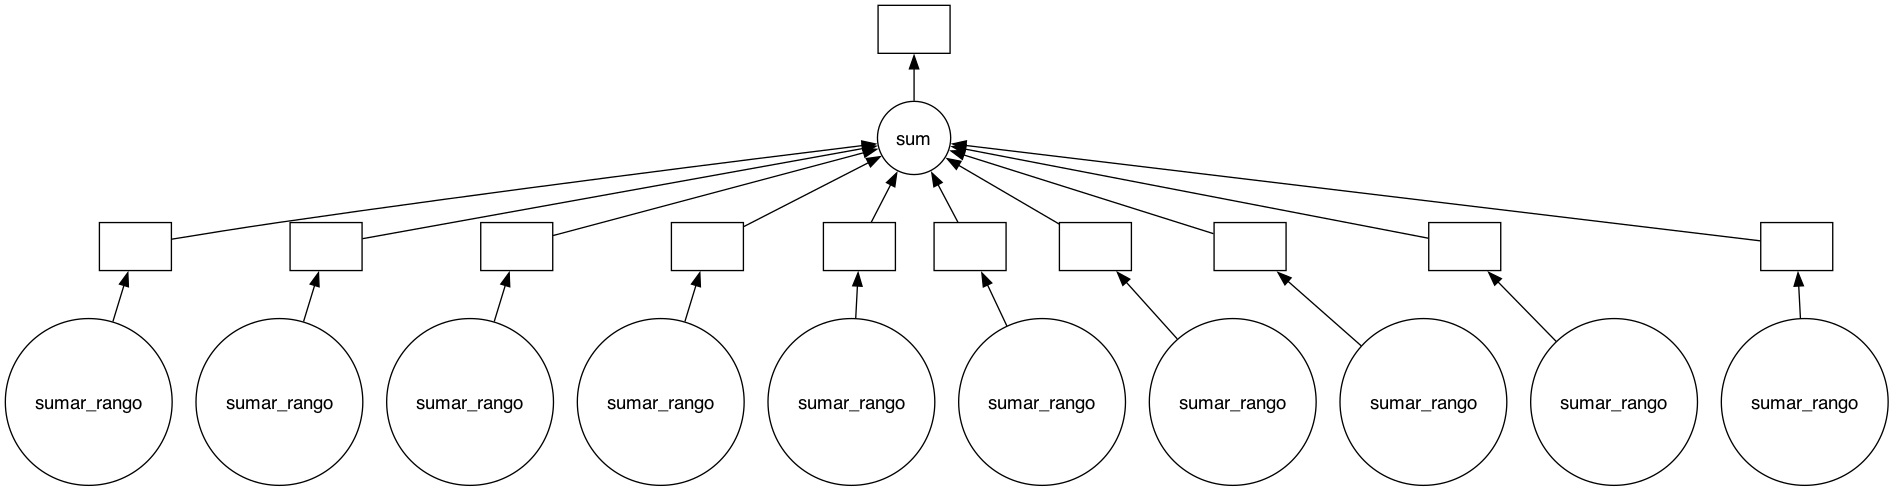

In [90]:
from dask import delayed

def sumar_rango(start, end):
    return sum(range(start, end))

# Crear tareas retrasadas
tareas = [delayed(sumar_rango)(i, i + 1000000) for i in range(0, 10000000, 1000000)]

# Sumar todos los resultados
resultado_total = delayed(sum)(tareas)

print("Resultado total:", resultado_total.compute())
resultado_total.visualize()


¿Por qué se divide en 10 operaciones? ¿En qué momento se realiza la operación (deja de ser lazy)?

Resultado final: 5


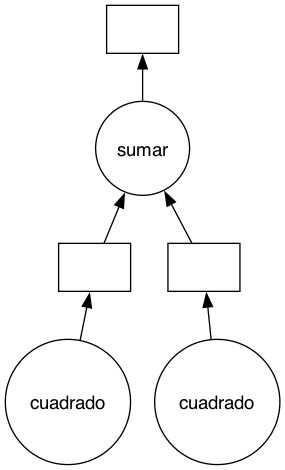

In [91]:
# Función para calcular el cuadrado
def cuadrado(x):
    return x ** 2

# Función para sumar dos números
def sumar(a, b):
    return a + b

# Crear tareas retrasadas
tareas = [delayed(cuadrado)(i) for i in range(1, 11)] 
resultado = delayed(sumar)(*tareas[:2])  

# Ejecutar el cálculo
print("Resultado final:", resultado.compute())
resultado.visualize()


¿Cuántos hilos / workers sería recomendable tener si estas operaciones fueran muy pesadas?

## 5. Futures

In [92]:
def calcular_potencia(base, exponente):
    return [base ** exponente for _ in range(100000)]

futuro1 = client.submit(calcular_potencia, 2, 10)
futuro2 = client.submit(calcular_potencia, 3, 5)

resultado1 = futuro1.result()
resultado2 = futuro2.result()

print("Resultados obtenidos")

Resultados obtenidos


¿Es secuencial o paralelo?

In [93]:
from dask.distributed import as_completed
import random

def calcular_cuadrado(n):
    return n ** 2

numeros = [random.randint(1, 1000) for _ in range(10000)]

# Enviar las tareas de cálculo de cuadrados a los trabajadores
futuros = [client.submit(calcular_cuadrado, num) for num in numeros]

# Recoger los resultados a medida que se completan
resultados = []
for futuro in as_completed(futuros):
    resultados.append(futuro.result())

print("Primeros 10 resultados:", resultados[:10])
print(f"Total de tareas completadas: {len(resultados)}")


Primeros 10 resultados: [786769, 646416, 37249, 37249, 254016, 8281, 120409, 660969, 697225, 31329]
Total de tareas completadas: 10000


¿Cuántas tareas se ejecutaron?

## 5.1 Flow para observar en la Interfaz

In [105]:
import time
import numpy as np

# Definimos las funciones de carga, procesamiento y guardado simuladas para obervar la paralelización
def load (x):
    time.sleep (0.2)    
    return np.arange (1000000) + x

def process (x):
    time. sleep (0.1)
    return x + 1

def save (x):
    time.sleep(0.4)
    return None

In [ ]:
%%time

inputs = range(200)
futures = []

for i in inputs:
    x = client.submit(load, i)
    y = client.submit(process, x)
    z = client.submit(save, y)
    futures.append(z)
    
result = [future.result() for future in futures]

CPU times: user 2.59 s, sys: 1.08 s, total: 3.66 s
Wall time: 19.1 s


Notar que, aquí estamos creando 600 futures (guardamos 200) y, luego se obtiene el resultado de esos 200. Es importante mencionar que, mientras tengamos un futuro apuntando a un resultado en memoria de Dask, Dask va a guardar esos datos en sus trabajadores. Esto es sumamente ineficiente, por lo que podemos hacer lo mismo con lo que se muestra abajo.

In [119]:
L = [client. submit(load, i) for i in range (200)]
L2 = client.map(process, L)
L3 = client.map(save, L2)

De esta forma, guardamos los resultados intermedios en una lista y después podemos limpiarlas:

In [ ]:
del L, L2

In [122]:
print(L3[0].result())

None


¿Por qué regresa None? ¿Hubo algún error al eliminar las listas, o se completó correctamente el futuro?

## 6. Ejercicio completo

In [95]:
import dask
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Simular datos financieros para un año
def generar_datos(anio, num_registros=10000):
    np.random.seed(anio)  # Semilla para reproducibilidad
    data = {
        "Year": [anio] * num_registros,
        "Revenue": np.random.randint(100, 10000, num_registros), 
        "Expenses": np.random.randint(50, 5000, num_registros), 
        "Category": np.random.choice(["A", "B", "C"], num_registros),
    }
    return pd.DataFrame(data)

# Filtrar registros con ingresos mayores a un umbral
def filtrar_ingresos(df, umbral=5000):
    return df[df["Revenue"] > umbral]

# Calcular estadísticas agregadas
def calcular_estadisticas(df):
    return {
        "MeanRevenue": df["Revenue"].mean(),
        "TotalRevenue": df["Revenue"].sum(),
        "TotalRecords": len(df),
    }

# Crear tareas retrasadas para procesar múltiples años
@dask.delayed
def procesar_anio(anio):
    """Genera, filtra y calcula estadísticas para un año."""
    datos = generar_datos(anio)
    datos_filtrados = filtrar_ingresos(datos)
    estadisticas = calcular_estadisticas(datos_filtrados)
    return estadisticas

# Lista de años a procesar
años = range(2010, 2024)

# Crear tareas para cada año
tareas = [procesar_anio(año) for año in años]

# Combinar los resultados de todos los años
@dask.delayed
def combinar_resultados(resultados):
    return pd.DataFrame(resultados)

# Ejecutar las tareas y combinar resultados
resultado_final = combinar_resultados(tareas)

# Calcular y mostrar el resultado
resultados = resultado_final.compute()
print(resultados)


    MeanRevenue  TotalRevenue  TotalRecords
0   7527.506548      37938633          5040
1   7488.805380      37863400          5056
2   7494.430800      37472154          5000
3   7505.010022      37442495          4989
4   7485.773502      37346524          4989
5   7521.769874      37751763          5019
6   7528.737987      38072828          5057
7   7495.601948      37717869          5032
8   7501.680671      38033521          5070
9   7504.775080      37403799          4984
10  7504.286545      38707110          5158
11  7508.590236      37527934          4998
12  7460.024980      37628366          5044
13  7491.002996      37507452          5007


¿Por qué podemos paralelizar las operaciones?